In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.word2vec import Word2Vec
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

The dataset has been previously labelled.

In [2]:
# Load the dataset from CSV file and show its head
df = pd.read_csv("/kaggle/input/vegan-20k/vegan_20k.csv", delimiter=";")
df

,ingredients,is_vegan
0,"[""1 cup shredded cheddar cheese"", ""1 cup chopp...",0
1,"[""1 pie crust"", ""1/2 lb. ground beef (you can ...",0
2,"[""2 small orange jello"", ""2 c. boiling water"",...",0
3,"[""12 (2 1/2-inch) square graham crackers, crum...",0
4,"[""1 (8 ounce.) pkg. cream cheese"", ""1 sm. jar ...",0
...,...,...
19995,"[""1 lb. hamburger, browned"", ""1 chopped onion""...",0
19996,"[""4 c. White Lily self-rising flour"", ""2 Tbsp....",0
19997,"[""1 c. mayonnaise"", ""1 tsp. onion, scraped"", ""...",0
19998,"[""1 1/2 c. sugar"", ""2 eggs"", ""2 c. Wesson oil""...",0


## Word2Vec Training

In [3]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Convert the 'ingredients' column to a list of lists
w2v_ingredients = df['ingredients'].apply(ast.literal_eval)

# Initialize an empty list to store the cleaned data
tokenized_ingredients = []

for ingredient_list in w2v_ingredients:
    cleaned_list = []
    
    for ingredient in ingredient_list:
        # Remove punctuation and convert to lowercase
        ingredient = re.sub(r'[^\w\s]', '', ingredient).lower()
        # Remove numbers and words nearby (e.g., '200g', '5ml', etc.)
        ingredient = re.sub(r'\b\d+(\w+)?\b', '', ingredient)
        
        # Tokenize
        tokens = ingredient.split()

         # Remove stopwords and single-character tokens
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

        # Add the cleaned tokens to the list
        cleaned_list.extend(tokens)

    # Append the cleaned list to the tokenized_ingredients list
    tokenized_ingredients.append(cleaned_list)

# Print a few samples to verify
print(tokenized_ingredients[:5])

[['cup', 'shredded', 'cheddar', 'cheese', 'cup', 'chopped', 'pimento', 'stuffed', 'olive', 'tablespoon', 'minced', 'onion', 'cup', 'dried', 'beef', 'chopped', 'cup', 'mayonnaise', 'loaf', 'sliced', 'rye', 'cocktail', 'bread'], ['pie', 'crust', 'lb', 'ground', 'beef', 'use', 'sausage', 'ham', 'bacon', 'mayonnaise', 'milk', 'eggs', 'tbsp', 'cornstarch', 'sliced', 'green', 'onions', 'grated', 'cheddar', 'cheese', 'diced', 'bell', 'pepper', 'tsp', 'salt', 'tsp', 'pepper'], ['small', 'orange', 'jello', 'boiling', 'water', 'small', 'crushed', 'pineapple', 'small', 'frozen', 'orange', 'juice', 'small', 'mandarin', 'oranges', 'pkg', 'instant', 'lemon', 'pudding', 'milk', 'pkg', 'dream', 'whip', 'prepared'], ['square', 'graham', 'crackers', 'crumbled', 'tbsp', 'reduced', 'calorie', 'margarine', 'melted', 'low', 'fat', 'cottage', 'cheese', 'pkg', 'sweetener', 'small', 'pkg', 'lemon', 'jello', 'sugar', 'free', 'boiling', 'water'], ['ounce', 'pkg', 'cream', 'cheese', 'sm', 'jar', 'old', 'english',

In [5]:
# Train the Word2Vec model
model = Word2Vec(
    sentences=tokenized_ingredients, 
    vector_size=50, 
    window=5, 
    min_count=5, 
    sg=1,  # 1 for Skip-Gram, 0 for CBOW
    epochs=10
)

# Save the model for later use
model.save("w2v_model.model")

Now, we need to convert the ingredient lists into fixed-length vectors using the trained Word2Vec model. 

In [6]:
# Combine each ingredient list back into a single string for TF-IDF processing
corpus = [" ".join(ing) for ing in tokenized_ingredients]

# Compute TF-IDF scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Extract TF-IDF feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

In [7]:
# Create a dictionary with word-to-tfidf mapping
tfidf_dict = dict(zip(feature_names, tfidf_vectorizer.idf_))

In [8]:
def vectorize_ingredients_tfidf(ingredient_list, model, tfidf_dict):
    vectors = []
    weights = []
    
    for word in ingredient_list:
        if word in model.wv and word in tfidf_dict:
            # Get Word2Vec vector
            word_vec = model.wv[word]
            
            # Get TF-IDF weight
            weight = tfidf_dict[word]
            
            # Apply weighting
            vectors.append(word_vec * weight)
            weights.append(weight)
    
    # Handle cases with no matching words
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    
    # Calculate weighted average
    return np.average(vectors, axis=0, weights=weights)

In [9]:
# Apply TF-IDF weighted vectorization to the dataset
ingredient_vectors_tfidf = np.array([vectorize_ingredients_tfidf(ing, model, tfidf_dict) for ing in tokenized_ingredients])

print(f"Shape of ingredient vectors with TF-IDF weighting: {ingredient_vectors_tfidf.shape}")

Shape of ingredient vectors with TF-IDF weighting: (20000, 50)


In [10]:
# Count the number of vegan and non-vegan samples
num_vegan = df[df['is_vegan'] == 1].shape[0]
num_non_vegan = df[df['is_vegan'] == 0].shape[0]

print(f"Number of vegan examples: {num_vegan}")
print(f"Number of non-vegan examples: {num_non_vegan}")

Number of vegan examples: 2176
Number of non-vegan examples: 17824


## Train a classifier

As we can see the dataset is highly unbalanced (as expected).

In [11]:
# Separate vegan and non-vegan samples
y = df['is_vegan'].values
X_vegan = ingredient_vectors_tfidf[y == 1]
X_non_vegan = ingredient_vectors_tfidf[y == 0]

y_vegan = y[y == 1]
y_non_vegan = y[y == 0]

# Determine the smaller class size
min_samples = min(len(X_vegan), len(X_non_vegan))

# Subsample both classes to ensure a 50/50 balance
X_vegan_balanced = X_vegan[:min_samples]
y_vegan_balanced = y_vegan[:min_samples]

X_non_vegan_balanced = X_non_vegan[:min_samples]
y_non_vegan_balanced = y_non_vegan[:min_samples]

# Concatenate the balanced dataset
X_balanced = np.vstack((X_vegan_balanced, X_non_vegan_balanced))
y_balanced = np.hstack((y_vegan_balanced, y_non_vegan_balanced))

# Shuffle the dataset
shuffled_indices = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[shuffled_indices]
y_balanced = y_balanced[shuffled_indices]

print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"Class distribution after balancing: {np.bincount(y_balanced)}")

Balanced dataset shape: (4352, 50)
Class distribution after balancing: [2176 2176]


In [12]:
# 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Check class distribution in train and test sets
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Training set size: (3481, 50)
Test set size: (871, 50)
Class distribution in training set: [1726 1755]
Class distribution in test set: [450 421]


In [13]:
# Train SVM with class weight adjustment
svm_model = SVC(kernel='linear', class_weight={0: 1, 1: 2})
svm_model.fit(X_train, y_train)

SVC(class_weight={0: 1, 1: 2}, kernel='linear')

Now, we evaluate the model.

Accuracy: 0.7933

Classification Report:
              precision    recall  f1-score   support

   Non-Vegan       0.88      0.69      0.78       450
       Vegan       0.73      0.90      0.81       421

    accuracy                           0.79       871
   macro avg       0.81      0.80      0.79       871
weighted avg       0.81      0.79      0.79       871



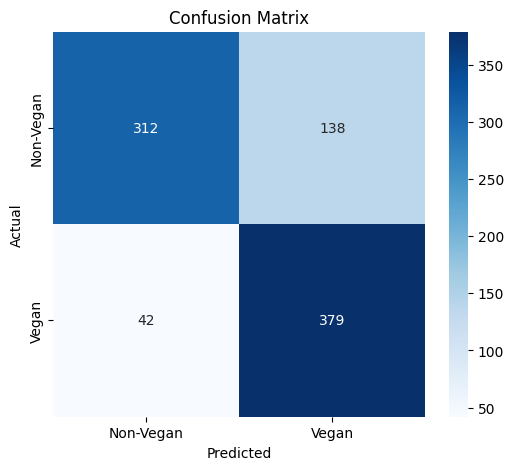

In [14]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Vegan", "Vegan"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Save the SVM model
joblib.dump(svm_model, "svm_model.pkl")

['svm_model.pkl']